In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [6]:
#Creating engine with the hawaii file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [8]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

- query for the data
- make the dataframe
- clean the dataframe
- plot the findings
- get summary statistics

In [12]:
#finding the last date
session.query(Measurement.date).order_by(desc(Measurement.date)).first()

('2017-08-23')

In [13]:
#empty lists to hold date and precipitation
date = []
prcp = []

#for loop to get the date and the precipitation
for row in session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').filter((Measurement.date <= '2017-08-23')):
    date.append(row[0])
    prcp.append(row[1])
    
#saving the data into a dictionary
d = {'date':date, 'precipitation': prcp}

#creating the dataframe
climate = pd.DataFrame(d)

#dropping the empty rows
climate = climate.dropna()

#settign the index
#climate = climate.set_index('date')

# Sort the dataframe by date
climate = climate.sort_values('date')
#climate = climate.sort_index()

In [14]:
climate.head(5)

,date,precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15


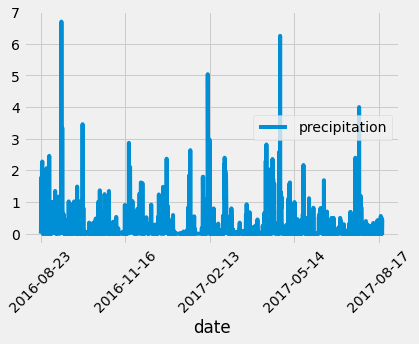

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
climate.plot(x = 'date', y = 'precipitation', rot = 45)
plt.show()
#climate.plot(kind = 'bar')

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

- find the total number of stations
- find the most active station
- query for the last 12 months of tobs
- plot with a histogram

In [35]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(stations)

9


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for row in session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))):
    print(row)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [72]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
maxTemp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
minTemp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
avgTemp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').scalar()
print(maxTemp)
print(minTemp)
print(round(avgTemp,2))

85.0
54.0
71.66


In [34]:
# Query the last 12 months of temperature observation data for this station
stmt = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').statement

#place this data into a histogram
df2 = pd.read_sql_query(stmt, session.bind)

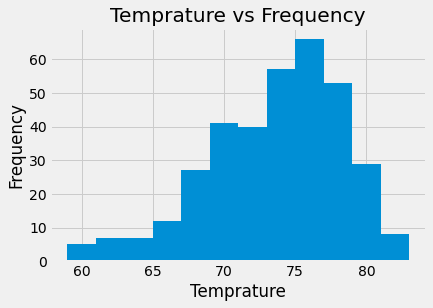

In [41]:
#creating a histogram with the data
plt.hist(df2['tobs'], bins = 12)
plt.title('Temprature vs Frequency')
plt.xlabel('Temprature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
